This project requires Python 3.7 or above:

In [28]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn >/ 1.0.1:

In [29]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Get the data

# Download the Data

In [30]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

houseprice = pd.read_csv("houseprice.csv")

# Take a quick look at the data structure

In [31]:
houseprice.head()

,Price,Sqr Ft,Longitude,Latitude,Lot Size,Beds,Bath,Year Built,Last Sold Year,Last Sold For,Address,City,State,Zipcode,Address Full
0,"$895,900","3,447 sqft",-112.081985,33.560055,"7,895 sqft",4.0,4.5,2019.0,NaN,NaN,"630 W Echo Ln Phoenix, AZ 85021",Phoenix,AZ,85021.0,"630 W Echo Ln, Phoenix, AZ 85021"
1,"$247,000","1,767 sqft",-96.676250,32.829227,"7,877 sqft",3.0,2.0,1954.0,NaN,NaN,"2367 Highwood Dr Dallas, TX 75228",Dallas,TX,75228.0,"2367 Highwood Dr, Dallas, TX 75228"
2,"$44,900","1,232 sqft",-78.825190,42.913000,"3,510 sqft",3.0,1.0,1900.0,NaN,NaN,"30 Hurlock Ave Buffalo, NY 14211",Buffalo,NY,14211.0,"30 Hurlock Ave, Buffalo, NY 14211"
3,"$959,000","1,417 sqft",-73.860170,40.722960,"2,598 sqft",3.0,2.0,1939.0,2009.0,"$532,000","6416 Alderton St Flushing, NY 11374",Flushing,NY,11374.0,"6416 Alderton St, Flushing, NY 11374"
4,"$83,500",440 sqft,-80.206314,25.937965,NaN,NaN,1.0,1971.0,2007.0,"$52,000","251 NW 177th St #A-123 Miami Gardens, FL 33169",Miami Gardens,FL,33169.0,"251 NW 177th St #A-123, Miami Gardens, FL 33169"


In [32]:
houseprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30006 entries, 0 to 30005
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           30006 non-null  object 
 1   Sqr Ft          27786 non-null  object 
 2   Longitude       30006 non-null  float64
 3   Latitude        30006 non-null  float64
 4   Lot Size        25490 non-null  object 
 5   Beds            27420 non-null  float64
 6   Bath            27496 non-null  float64
 7   Year Built      26258 non-null  float64
 8   Last Sold Year  14213 non-null  float64
 9   Last Sold For   14213 non-null  object 
 10  Address         30006 non-null  object 
 11  City            30006 non-null  object 
 12  State           30006 non-null  object 
 13  Zipcode         30003 non-null  float64
 14  Address Full    30006 non-null  object 
dtypes: float64(7), object(8)
memory usage: 3.4+ MB


In [33]:
houseprice["Beds"].value_counts()

Beds
3.0     10929
4.0      6975
2.0      4990
5.0      2213
1.0      1329
6.0       624
7.0       143
8.0       104
9.0        42
10.0       23
12.0       15
11.0       10
20.0        3
14.0        3
18.0        2
16.0        2
64.0        2
15.0        2
44.0        2
36.0        1
27.0        1
23.0        1
65.0        1
35.0        1
24.0        1
13.0        1
Name: count, dtype: int64

In [34]:
houseprice.describe()

,Longitude,Latitude,Beds,Bath,Year Built,Last Sold Year,Zipcode
count,30006.000000,30006.000000,27420.000000,27496.000000,26258.000000,14213.000000,30003.000000
mean,-95.167341,36.158007,3.288658,2.578688,1973.140224,2011.110673,59349.268440
std,15.454027,5.500075,1.472238,1.448891,34.512400,6.596002,27206.130444
min,-150.047160,25.550295,1.000000,0.750000,1800.000000,1987.000000,2108.000000
25%,-106.742751,32.747084,3.000000,2.000000,1950.000000,2006.000000,33137.000000
50%,-93.390977,36.016481,3.000000,2.000000,1978.000000,2013.000000,68124.000000
75%,-81.638904,40.017658,4.000000,3.000000,2004.000000,2017.000000,85016.000000
max,-70.997740,61.442024,65.000000,98.000000,2019.000000,2019.000000,99587.000000


Code to save the figures as high-res  PNG's 

In [35]:
IMAGES_PATH = Path() / "images" / "end_to_end_project" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
import matplotlib.pyplot as plt

#next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

houseprice.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")
plt.show()

## Create a Test Set

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(houseprice, test_size=0.2, random_state=42)

## Discover and Visualize the Data to Gain Insights

In [ ]:
houseprice = train_set.copy()

Visualizing Geographical Data

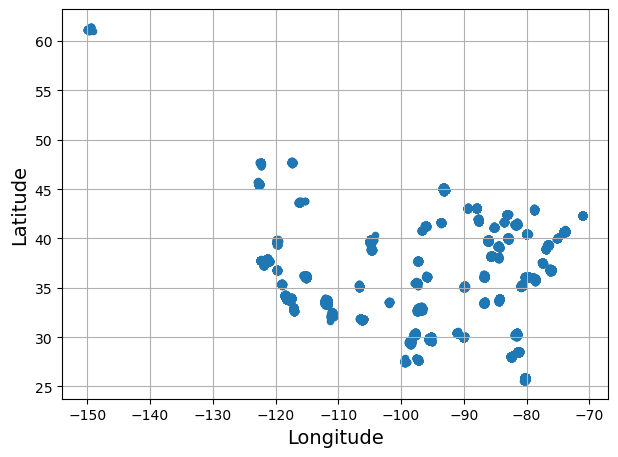

In [ ]:
houseprice.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
save_fig("bad_visualisation_plot") #extra code
plt.show()

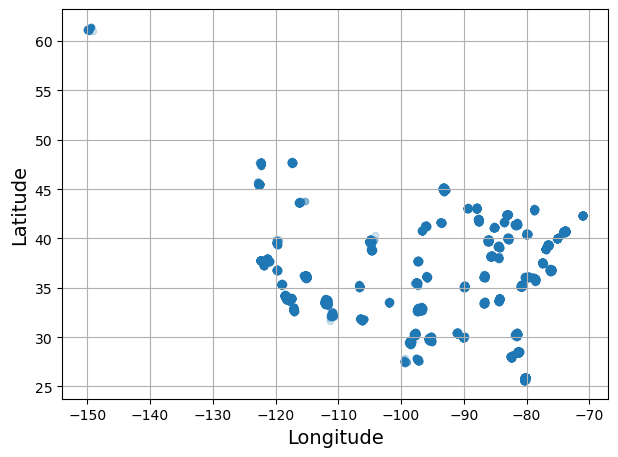

In [ ]:
houseprice.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, alpha=0.2)
save_fig("better_visualisation_plot")
plt.show()

# Clean the Data

In [ ]:
houseprice_1 = houseprice.copy()

In [ ]:
houseprice_1.columns

Index(['Price', 'Sqr Ft', 'Longitude', 'Latitude', 'Lot Size', 'Beds', 'Bath',
       'Year Built', 'Last Sold Year', 'Last Sold For', 'Address', 'City',
       'State', 'Zipcode', 'Address Full'],
      dtype='object')

In [ ]:
colums_to_clean = ['Price', 'Sqr Ft', 'Lot Size', 'Last Sold For']

for col in colums_to_clean:
    houseprice_1[col] = pd.to_numeric(
        houseprice_1[col]
        .str.replace(r'[$,+] |sqft|acres', '', regex=True),
        errors='coerce'
    )

Show all null values

In [ ]:
null_rows_idx = houseprice_1.isnull().any(axis=1)
houseprice_1.loc[null_rows_idx].head()

,Price,Sqr Ft,Longitude,Latitude,Lot Size,Beds,Bath,Year Built,Last Sold Year,Last Sold For,Address,City,State,Zipcode,Address Full
251,NaN,NaN,-98.36617,29.589867,0.25,4.0,3.0,2019.0,NaN,NaN,"16407 Escalera Pl San Antonio, TX 78247",San Antonio,TX,78247.0,"16407 Escalera Pl, San Antonio, TX 78247"
25472,NaN,NaN,-149.78800,61.094100,1.77,NaN,NaN,NaN,NaN,NaN,"L12 B3 Snow Bear Cir Anchorage, AK 99516",Anchorage,AK,99516.0,"L12 B3 Snow Bear Cir, Anchorage, AK 99516"
618,NaN,NaN,-104.82194,38.932410,NaN,5.0,3.0,1977.0,2011.0,NaN,"300 Raven Hills Rd Colorado Springs, CO 80919",Colorado Springs,CO,80919.0,"300 Raven Hills Rd, Colorado Springs, CO 80919"
17092,NaN,NaN,-115.08373,36.106308,NaN,3.0,2.0,1971.0,2019.0,NaN,"4150 Seattle Ave Las Vegas, NV 89121",Las Vegas,NV,89121.0,"4150 Seattle Ave, Las Vegas, NV 89121"
20762,NaN,NaN,-87.61954,41.854645,NaN,2.0,2.0,2007.0,2008.0,NaN,"320 E 21st St #201 Chicago, IL 60616",Chicago,IL,60616.0,"320 E 21st St #201, Chicago, IL 60616"


In [ ]:
houseprice_1.drop("Last Sold Year", axis=1, inplace=True)
houseprice_1.loc[null_rows_idx].head()

,Price,Sqr Ft,Longitude,Latitude,Lot Size,Beds,Bath,Year Built,Last Sold For,Address,City,State,Zipcode,Address Full
251,NaN,NaN,-98.36617,29.589867,0.25,4.0,3.0,2019.0,NaN,"16407 Escalera Pl San Antonio, TX 78247",San Antonio,TX,78247.0,"16407 Escalera Pl, San Antonio, TX 78247"
25472,NaN,NaN,-149.78800,61.094100,1.77,NaN,NaN,NaN,NaN,"L12 B3 Snow Bear Cir Anchorage, AK 99516",Anchorage,AK,99516.0,"L12 B3 Snow Bear Cir, Anchorage, AK 99516"
618,NaN,NaN,-104.82194,38.932410,NaN,5.0,3.0,1977.0,NaN,"300 Raven Hills Rd Colorado Springs, CO 80919",Colorado Springs,CO,80919.0,"300 Raven Hills Rd, Colorado Springs, CO 80919"
17092,NaN,NaN,-115.08373,36.106308,NaN,3.0,2.0,1971.0,NaN,"4150 Seattle Ave Las Vegas, NV 89121",Las Vegas,NV,89121.0,"4150 Seattle Ave, Las Vegas, NV 89121"
20762,NaN,NaN,-87.61954,41.854645,NaN,2.0,2.0,2007.0,NaN,"320 E 21st St #201 Chicago, IL 60616",Chicago,IL,60616.0,"320 E 21st St #201, Chicago, IL 60616"


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [ ]:
houseprice_num = houseprice_1.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(houseprice_num)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_

array([           nan,  8.3500000e+02, -9.3439403e+01,  3.6017143e+01,
        1.1100000e+00,  3.0000000e+00,  2.0000000e+00,  1.9780000e+03,
                  nan,  6.8116000e+04])

Check that it is the same as manually computing the median of each attribute:

In [ ]:
houseprice_num.median().values

array([           nan,  8.3500000e+02, -9.3439403e+01,  3.6017143e+01,
        1.1100000e+00,  3.0000000e+00,  2.0000000e+00,  1.9780000e+03,
                  nan,  6.8116000e+04])

Transforming the training set:

In [ ]:
X = imputer.transform(houseprice_num)

c:\Users\masun\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Price' 'Last Sold For']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [ ]:
imputer.feature_names_in_

array(['Price', 'Sqr Ft', 'Longitude', 'Latitude', 'Lot Size', 'Beds',
       'Bath', 'Year Built', 'Last Sold For', 'Zipcode'], dtype=object)

In [ ]:
print(X.shape)
print(houseprice_num.shape)

(24004, 8)
(24004, 10)


In [ ]:
houseprice_tr = pd.DataFrame(X, houseprice_num.columns, 
                             houseprice_num.index)

ValueError: Shape of passed values is (24004, 8), indices imply (24004, 10)